In [1]:
import numpy
import pandas
import keras
from matplotlib import pyplot
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth'] # 'sepallength', 'sepalwidth', 'petallength', 'petalwidth'
class_col = 'flower'
my_class = 'Iris-versicolor' # 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'

# TRAINING PARAMETERS
max_hidden_neurons = 5
hidden_neuron_activation = 'tanh' # 'tanh', 'relu', 'sigmoid'
my_metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
#quantidade de loops q vai esperar ate q o erro de teste comece a aumentar 
my_patience = 300
max_epoch = 2*my_patience
min_improvement = 0.01
min_neuron_gain = 0.01
min_median_gain = 0.01
rmsprop_lr = 0.001
adam_initial_lr = 0.01
adam_decay_steps = max_epoch
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True #se comecar o erro a subir, volta pra onde tava bom

# SEED que controla a aleatoriedade 
random_seed = 33
n_k_folds = 5 #quantas partes o dataset vai ser dividido

keras.utils.set_random_seed(random_seed)


my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv('datasets/iris.data', sep=',', decimal='.')
iris = iris[my_vars_w_class]


<Axes: >

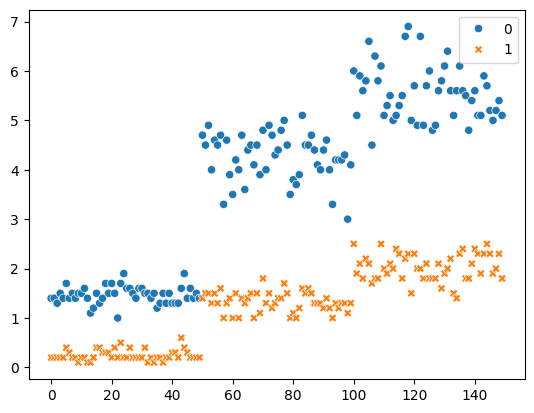

In [7]:
# ROBUST TRAINING PROCEDURE

# Inicializando o otimizador ADAM
adam_lr_schedule = keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                               adam_decay_steps,
                                                               adam_lr_decay)

# my_optimizers = {'adam': keras.optimizers.Adam(learning_rate=adam_lr_schedule),
#                  'rmsprop': keras.optimizers.RMSprop(learning_rate=rmsprop_lr)}

my_optimizers = ['adam', 'rmsprop']

X = iris[my_vars].to_numpy() 
Y = (iris['flower'] == my_class).astype(float).to_numpy()[:, numpy.newaxis] # 0 / 1
import seaborn
seaborn.scatterplot(X)

<Axes: >

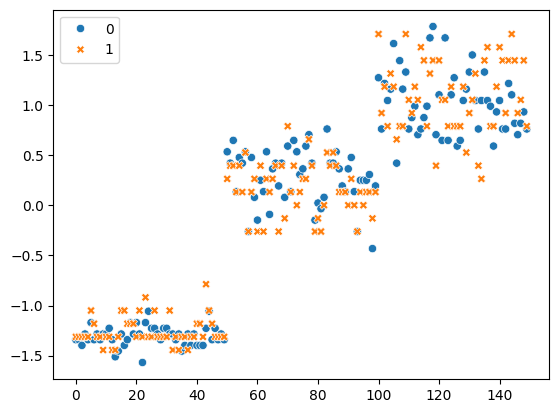

In [9]:
# Normalizando as features X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)
import seaborn
seaborn.scatterplot(X_scaled)

In [19]:

# DIVIDE EM K PEDACOS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y)

# TRAINING LOOP
# FOR EACH OPTIMIZER
best_net_name = None
best_net = None
best_metric = 0.0
best_metric_val = 0.0
metric_lower_bound = 0.0
metric_median = 0.0
result_list = []
print('TRAINING PROCEDURE STARTED...\n')
for n_neuron in numpy.arange(1, max_hidden_neurons+1):
    ix_fold = 1
    #divisao os grupos de treino e teste, ele faz pelos indices
    for train_index, test_index in sk_folds.split(X_scaled, Y):
        # pegar o dado do teste  e treino   a partir dos indices da divisao feita pelo skfolds
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        #utilizar os dois otimizadores para comparar ADAM e RMSPROP
        for optimizer_name in my_optimizers:
            # Configurando a rede
            inputs = keras.Input(shape=(len(my_vars), ))
            hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
            outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
            model_name = '{}-N{}F{}_{}'.format(optimizer_name.upper(), n_neuron, ix_fold, my_class)
            my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
            val_metric_name = 'val_{}'.format(my_metric)

            if optimizer_name == 'adam':
                adam_lr_schedule = keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                                                adam_decay_steps,
                                                                                adam_lr_decay)
                optimizer = keras.optimizers.Adam(learning_rate=adam_lr_schedule)
            elif optimizer_name == 'rmsprop':
                optimizer = keras.optimizers.RMSprop(learning_rate=rmsprop_lr)
            #Usar o otimizador com erro medio quadratico 
            my_net.compile(optimizer=optimizer, loss='mse', metrics=[my_metric])
            
            #early stop com foco no erro do grupo de validacao
            es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
            #early stop com foco na acuracia dos testes
            es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)


            # AJUSTANDO OS PESOS
            my_class_weight = Y_train.shape[0]/Y_train.sum()
            other_class_weight = Y_train.shape[0]/(Y_train==0).sum()
            class_weights = {0: other_class_weight, 1: my_class_weight}
            #iniciando a rede para tentar encontrar o modelo
            history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                 epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric], class_weight=class_weights)

            # UNPACK TRAINING RESULTS
            model_loss = history.history['loss'][-1]
            model_val_loss = history.history['val_loss'][-1]
            metric_val = history.history[my_metric][-1]
            val_metric_val = history.history[val_metric_name][-1]
            n_epochs = len(history.history['val_loss'])

            # CHECK IF BEST NET
            best_net_txt = ''
            is_best = False
            if ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                best_net_name = model_name
                best_optimizer_name = optimizer_name
                best_optimizer = optimizer
                best_net = my_net
                best_neurons = n_neuron
                best_metric = metric_val
                best_metric_val = val_metric_val
                best_net_txt = '**Best NET!**'
                is_best = True

            result_dict = {'model_name': model_name,
                            'optimizer_name' : optimizer_name,
                            'optimizer': optimizer,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            my_metric: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'is_best': is_best,
                            'net': my_net,
                            'history': history}
            result_list.append(result_dict)

            print('{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% {}'.format(model_name, n_epochs, model_loss, model_val_loss, my_metric,
                                                                                                100.0*metric_val, val_metric_name, 100.0*val_metric_val, best_net_txt))

            # IF MAXIMIZED METRICS BREAK
            maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

            if maximized_metrics:
                break
        
        if maximized_metrics:
            break

        print('')
        ix_fold += 1
        
    dont_need_extra_neurons = False
    if n_neuron > 1:
        
        # Caso ja tenha atingido o patamar desejado, pode parar de incrementar neuronios na camada oculta
        if best_neurons < n_neuron:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(n_neuron, my_metric))
            break

    # GET LOWER BOUND OF WINNING ALGORITHM
    df_results = pandas.DataFrame(result_list)
    lower_bound_est = df_results[(df_results.optimizer_name == best_optimizer_name) & (df_results.neurons == n_neuron)][val_metric_name].min()
    median_est = df_results[(df_results.optimizer_name == best_optimizer_name) & (df_results.neurons == n_neuron)][val_metric_name].median()

    # TEST IF LOWER BOUND IMPROVED AND MEDIAN IMPROVED
    fold_improve = False
    if n_neuron > 1:
        neuron_gain = 0.0
        if lower_bound_est > metric_lower_bound or median_est > metric_median:
            if metric_lower_bound > 0.0 and metric_median > 0.0:
                neuron_gain = lower_bound_est/metric_lower_bound - 1.0
                median_gain = median_est/metric_median - 1.0
                if neuron_gain <= min_neuron_gain and median_gain <= min_median_gain:
                    print('NETs w {} neurons didnt improve min {} {:.1f} neuron gain {:.1f} / min {:.1f} or median gain {:.1f} / min {:.1f}!'.format(n_neuron, val_metric_name, 100.0*lower_bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain, 100.0*median_gain, 100.0*min_median_gain))
                    fold_improve = True
                    break
                else:
                    print('NETs Neuron Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}% | Median Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}%'.format(n_neuron, 100.0*metric_lower_bound, 100.0*lower_bound_est ,100.0*neuron_gain, n_neuron, 100.0*metric_median, 100.0*median_est, 100.0*median_gain))
            else:
                print('NET Neural Gain From 0.0 >> {:.1f}% and Median Gain From 0.0 >> {:.1f}%'.format(100.0*lower_bound_est, 100.0*median_est))
        else:
            print('No Lower Bound Gain on {} neurons for {}: {:.1f} >> {:.1f} or no Median Gain on {} neurons for {}: {:.1f} >> {:.1f}'.format(n_neuron, best_optimizer_name, 100.0*metric_lower_bound, 100.0*lower_bound_est, n_neuron, best_optimizer_name, 100.0*metric_median, 100.0*median_est))
            fold_improve = False
            break
    else:
        print('NET Lower Bound Estimation for {} neuron: {:.1f}% | Median {:.1f}%'.format(n_neuron, 100.0*lower_bound_est, 100.0*median_est))
    
    metric_lower_bound = lower_bound_est
    metric_median = median_est
    print('')

    if maximized_metrics or dont_need_extra_neurons:
        break

TRAINING PROCEDURE STARTED...



KeyboardInterrupt: 

In [ ]:
df_results.sort_values(by=[f'val_{my_metric}', my_metric, 'neurons'], ascending=[False, False, True])
# AGGREGATE BY NEURONS AND OPTIMIZER
df_results_agg = df_results.groupby(['neurons', 'optimizer_name']).agg({f'val_{my_metric}': ['mean', 'std', 'min', 'max']}).reset_index()
df_results_agg.columns = ['neurons', 'optimizer_name', 'mean', 'std', 'min', 'max']
df_results_agg = df_results_agg.sort_values(by=['min', 'neurons'], ascending=[False, True])
df_results_agg

In [ ]:
best_hyperconfig = df_results_agg.iloc[0]
best_neurons = int(best_hyperconfig['neurons'])
best_optimizer_name = best_hyperconfig['optimizer_name']
best_hyperconfig

In [ ]:
best_rows = df_results[(df_results.neurons == best_neurons) & (df_results.optimizer_name == best_optimizer_name)]
best_net_name = best_rows['model_name'].values[0]
best_optimizer = best_rows['optimizer'].values[0]
best_net = best_rows['net'].values[0]
best_neurons = best_rows['neurons'].values[0]
best_metric = best_rows[my_metric].values[0]
best_metric_val = best_rows[val_metric_name].values[0]
best_history = best_rows['history'].values[0]

best_rows
